# Digit Recognizer

https://www.kaggle.com/c/digit-recognizer/overview

keyword : pytorch, machine learning, deep learning, computer vision, MNIST <br>

<b>My github : https://github.com/h5jam

Dependencies

pytorch==1.7.1<br>
torchvision==0.8.2<br>
cuda==11.0<br>

### 1. Import module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F

import tqdm

### 2. Load data
Load data using kaggle API. If you don't installed, you could manually install from a link ( https://www.kaggle.com/c/digit-recognizer/data )<br><br>

dataset
- train.csv<br>
- test.csv<br>
- sample_submission.csv<br>

In [2]:
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!mkdir dataset

하위 디렉터리 또는 파일 dataset이(가) 이미 있습니다.


In [4]:
import zipfile
import os

zipfile.ZipFile('digit-recognizer.zip').extractall('./dataset')

### 3. Prepare dataset 
The first column means a digit label,the others are value of every pixel.<br>
785 columns include 784 pixels (28\*28) and one label.

In [29]:
train = pd.read_csv('./dataset/train.csv', dtype=np.float32)
final_test = pd.read_csv('./dataset/test.csv', dtype=np.float32)
sample_submission = pd.read_csv('./dataset/sample_submission.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB


##### train & test split
train : val = 8 : 2

In [7]:
targets = train.label.values # [0,1,2...9]
features_normalized = train.loc[:, train.columns != 'label'].values / 255.0

feat_train, feat_test, target_train, target_test = train_test_split(features_normalized, targets, test_size = 0.2, random_state=1010)

feat_train = torch.from_numpy(feat_train)
target_train = torch.from_numpy(target_train).type(torch.LongTensor)

feat_test = torch.from_numpy(feat_test)
target_test = torch.from_numpy(target_test).type(torch.LongTensor)

##### generate data loader

In [8]:
batch_size = 64
n_iters = 10000

num_of_epochs = n_iters / (len(feat_train) / batch_size )
num_of_epochs = int(num_of_epochs)

train = torch.utils.data.TensorDataset(feat_train, target_train)
test = torch.utils.data.TensorDataset(feat_test, target_test)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

##### view example image

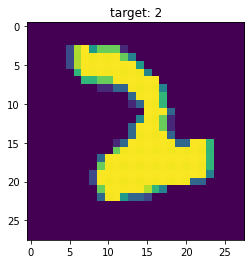

In [9]:
plt.imshow(feat_train[0].reshape(28,28))
plt.title('target: '+str(target_train[0].item()))
plt.show()

### 4. Create Model

I used a model from https://www.kaggle.com/abhinand05/mnist-introduction-to-computervision-with-pytorch . I thought that this model has a simple structure. In addition, training performance is not bad too.

In [10]:
class digit_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        self.log_softmax = F.log_softmax
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = self.log_softmax(self.fc5(x), dim=1)
        
        return x

### 5. Training and Validation
Above part, I splitted train dataset to train & validation. 

In [11]:
def evaluation(net, data_loader, device='cpu'):
    net.eval()
    label_gt = []
    label_preds = []
    
    for img,label in data_loader:
        img = img.to(device)
        label = label.to(device)
        
        with torch.no_grad():
            _, label_pred = net(img).max(1)
        
        label_gt.append(label)
        label_preds.append(label_pred)
    
    label_gt = torch.cat(label_gt)
    label_preds = torch.cat(label_preds)
    
    acc = (label_gt == label_preds).float().sum() / len(label_gt)
    
    return acc.item()

In [12]:
def train(net, train_loader, test_loader,
              optimizer_cls = optim.Adam, lr=0.01, loss_fn = nn.CrossEntropyLoss(),
              n_epochs = 10, device='cpu'):
    train_losses = []
    train_acc = []
    val_acc = []

    optimizer = optimizer_cls(net.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        running_loss = 0.0

        net.train()
        n = 0
        n_acc = 0
        
        for i, (img,label) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
            img = img.to(device)
            label = label.to(device)
            output = net(img)
            
            loss = loss_fn(output, label)
            
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            n += len(img)
            _, label_pred = output.max(1)
            n_acc += (label == label_pred).float().sum().item()
        
        train_losses.append(running_loss/i)
        train_acc.append(n_acc/n)
        
        val_acc.append(evaluation(net, test_loader, device))
        
        print('[', epoch, ']', train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
    
    return train_losses, train_acc, val_acc

In [16]:
net = digit_classifier()
net.to('cuda:0')

train_losses, train_acc, val_acc = train(net, train_loader, test_loader, n_epochs=num_of_epochs, device='cuda:0', lr=0.001)

100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 294.28it/s]


[ 0 ] 0.4997316507110728 0.84125 0.9464285373687744


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 298.16it/s]


[ 1 ] 0.18222828833599583 0.9483928571428571 0.9640476107597351


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 299.07it/s]


[ 2 ] 0.12954214867204428 0.963125 0.9674999713897705


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 303.41it/s]


[ 3 ] 0.10877936846000776 0.9681547619047619 0.9702380895614624


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 307.19it/s]


[ 4 ] 0.08208467703595232 0.9769047619047619 0.9683333039283752


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 304.92it/s]


[ 5 ] 0.06880206467436256 0.9806547619047619 0.972261905670166


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 307.47it/s]


[ 6 ] 0.0630387055157961 0.9806547619047619 0.9747619032859802


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 297.12it/s]


[ 7 ] 0.057503375566239245 0.9832440476190476 0.9732142686843872


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 293.05it/s]


[ 8 ] 0.04964031451355083 0.9849404761904762 0.9778571128845215


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 288.01it/s]


[ 9 ] 0.043419370598907096 0.9873809523809524 0.9714285731315613


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 290.01it/s]


[ 10 ] 0.04657807113263509 0.9862797619047619 0.9776190519332886


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 290.30it/s]


[ 11 ] 0.04133178099878475 0.9873511904761905 0.9739285707473755


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 289.54it/s]


[ 12 ] 0.04004535805292913 0.9877976190476191 0.9783332943916321


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 284.70it/s]


[ 13 ] 0.029819613685983057 0.9915178571428571 0.9770237803459167


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 298.88it/s]


[ 14 ] 0.03201958004230883 0.9904166666666666 0.9770237803459167


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 298.71it/s]


[ 15 ] 0.02901734726137805 0.9914285714285714 0.9785714149475098


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 302.14it/s]


[ 16 ] 0.028316474950124827 0.9917261904761905 0.977738082408905


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 297.14it/s]


[ 17 ] 0.029784275519054035 0.9916369047619048 0.9802380800247192


100%|███████████████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 289.96it/s]


[ 18 ] 0.02819854401771596 0.9914285714285714 0.9746428728103638


### 6. Result

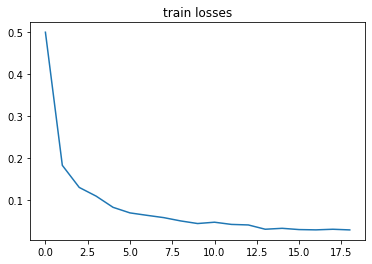

In [19]:
%matplotlib inline

plt.title('train losses')
plt.plot(train_losses, label='train losses')
plt.show()

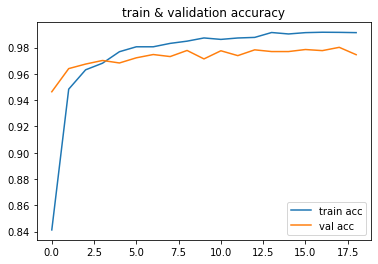

In [21]:
plt.title('train & validation accuracy')
plt.plot(train_acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.legend()
plt.show()

### 7. Submissions

In [42]:
sample_submission.head(5)

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [30]:
final_test_normalized = final_test.loc[:, final_test.columns!='label'].values/255.0
final_test_dataset = torch.from_numpy(final_test_normalized)

final_test_loader = DataLoader(final_test_dataset,batch_size=100,shuffle=False)

In [36]:
predictions = []

with torch.no_grad():
    net.eval()
    for images in final_test_loader:
        images = images.to('cuda:0')
        output = net(images)
        predicts = torch.exp(output)
        _, top_class = predicts.topk(1, dim=1)
        top_class = top_class.cpu()
        predictions += top_class.numpy().tolist()

predictions = np.array(predictions).flatten()

In [45]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),"Label": predictions})
submissions.to_csv("submission.csv", index=False, header=True)

In [46]:
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "my first submission"

Successfully submitted to Digit Recognizer



  0%|          | 0.00/235k [00:00<?, ?B/s]
  3%|3         | 8.00k/235k [00:00<00:03, 62.3kB/s]
 78%|#######8  | 184k/235k [00:00<00:00, 816kB/s]  
100%|##########| 235k/235k [00:09<00:00, 26.3kB/s]


### References

https://www.kaggle.com/abhinand05/mnist-introduction-to-computervision-with-pytorch <br>
https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers